In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from rslds import RSLDS

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
#V-= np.mean(V)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
#C_syn_part = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")[1:]
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)

In [3]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
hid_no = 3 # H
sub_no = 4 # N
state_no = 3 # K
enc_no = 12
in_no = 299
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_length = 50000
batch_size = 9
iter_no = 9990
epoch_no = iter_no*batch_length*batch_size//T_train

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
C_syn = torch.zeros(sub_no, in_no).to(device)
#C_syn[:5] = torch.from_numpy(C_syn_part)
"""
for i in range(in_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn[:,i] = 0
        C_syn[0,i] = 1
    elif den == den_idx[1]:
        C_syn[:,i] = 0
        C_syn[1,i] = 1
    elif den == den_idx[2]:
        C_syn[:,i] = 0
        C_syn[2,i] = 1
    elif den == den_idx[3]:
        C_syn[:,i] = 0
        C_syn[3,i] = 1
"""
C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1

In [6]:
model = RSLDS(25000, sub_no, state_no, hid_no, enc_no, batch_size, C_syn, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2352


In [7]:
#temp_list = np.logspace(1,0,20)
temp_list = np.logspace(0,-3,30)
temp_count = 0
beta = 1

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    if (i%20 == 19) & (temp_count < 29):
        temp_count += 1
    temp = temp_list[temp_count]
    if i%20 == 19:
        beta *= 0.75
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    Y_prob, init_prob, seq_prob, gamma_prior_prob = model(batch_V[:,10000:35000], batch_E_neural[:,10000:35000,e_idx], temp, beta)
    
    loss = -Y_prob - init_prob - seq_prob - gamma_prior_prob*beta
        
    loss.backward()    
    optimizer.step()
    
    print(i, np.round(-Y_prob.item(), 6),
          np.round(-init_prob.item()-seq_prob.item(), 6),
          np.round(-gamma_prior_prob.item(), 6),
         np.round(time.time() - s, 5))
    
    if (i%20 == 19):
        model.eval()
        test_V_pred, test_X_out, test_Z_out = model.test(test_E_neural[10000:35000,e_idx])
                 
        test_score = explained_variance_score(V_test[10000:35000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:35000]-test_V_pred)**2).item()
        
        print("TEST", i, np.round(test_score,6),
              np.round(test_mse,6))
    

<ipython-input-7-c06f0ed670da>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 13762.296875 1091444.63793 988797.1875 16.58001
1 12377.563477 1089088.35131 988809.125 15.74768
2 10938.230469 1090321.651533 988823.5 15.80738
3 8858.070312 1093281.005067 988839.125 15.77905
4 8523.253906 1099001.768796 988856.0 15.79502
5 9315.852539 1105774.926626 988874.1875 15.7961
6 9640.863281 1112241.2109 988894.25 16.02749
7 8228.513672 1117526.112003 988916.6875 15.85225
8 7364.177246 1122839.377536 988943.75 15.90259
9 7250.526367 1129292.23366 988977.5625 15.92962
10 7221.641113 1136500.548324 989020.25 16.30818
11 6272.42041 1143797.460968 989072.8125 16.97349
12 5130.355957 1152277.897764 989139.125 17.07353
13 5379.303711 1164742.864667 989227.5 15.94122
14 4909.154297 1178090.362814 989338.0625 16.95488
15 4619.583008 1194335.532699 989480.125 15.8365
16 4626.782227 1213319.128507 989660.3125 17.05194
17 4545.352051 1234150.768434 989884.0 15.87363
18 4296.190918 1257508.831389 990163.6875 15.72995
19 4080.821289 1283509.072452 991321.0 17.01606
TEST 19 0.001335 0.0

162 11676.642578 5424.235596 55972696.0 15.9259
163 12358.460938 5306.419434 55985256.0 17.17569
164 12690.972656 5309.619141 55995856.0 16.15449
165 13302.78418 5198.802979 56007856.0 16.40364
166 12337.561523 5177.824219 56017632.0 16.19879
167 12584.867188 5072.741943 56026748.0 16.91669
168 11771.357422 5074.952637 56034672.0 17.19206
169 10847.554688 5036.543701 56041896.0 15.95464
170 12196.175781 4984.154297 56049268.0 16.62218
171 12256.489258 4940.98877 56054656.0 16.07389
172 13329.951172 4911.363037 56059552.0 16.38398
173 12670.389648 4943.4021 56062708.0 16.54385
174 12290.680664 4856.234131 56066568.0 15.89386
175 13183.705078 4829.251221 56068432.0 15.87196
176 13312.857422 4815.382324 56070536.0 16.13045
177 12542.545898 4722.347412 56071256.0 15.86313
178 11736.282227 4757.718994 56071344.0 16.10855
179 14054.245117 4736.698242 65373652.0 15.99362
TEST 179 -0.030525 0.054718
180 14126.138672 4730.643555 65372700.0 16.47756
181 12392.802734 4682.321045 65370960.0 16.477

325 12063.209961 3588.373047 219152256.0 15.97962
326 11872.441406 3600.013306 219100544.0 15.96107
327 12299.454102 3649.40686 219074240.0 15.94324
328 12500.027344 3607.639648 219051120.0 15.939
329 11622.688477 3622.295654 219051872.0 15.92416
330 11849.269531 3669.536987 219069728.0 15.94832
331 12441.955078 3649.927002 219092960.0 15.89594
332 11641.550781 3671.263916 219136176.0 15.93062
333 13136.017578 3718.727173 219192928.0 16.62529
334 11468.058594 3706.375977 219257440.0 15.96459
335 12432.880859 3729.299561 219340688.0 15.91684
336 11942.041016 3833.404297 219432864.0 16.04484
337 12391.183594 3781.171875 219538432.0 16.17112
338 12060.270508 3807.370972 219656768.0 16.36501
339 12487.160156 3833.108643 274517056.0 16.44953
TEST 339 -0.005265 0.052931
340 12402.027344 3902.339966 274686656.0 16.05396
341 13157.849609 3887.012573 274868128.0 16.38178
342 11636.177734 3961.368286 275051776.0 16.32101
343 12344.636719 3943.543335 275255872.0 17.22837
344 11552.40625 3969.1386

489 12644.347656 7426.958252 1479201408.0 16.13769
490 11834.755859 7495.171387 1479401088.0 16.2722
491 14013.794922 7540.377441 1480296960.0 16.2164
492 11374.460938 7428.349121 1479849984.0 16.0162
493 12485.926758 7550.52002 1480920832.0 17.20619
494 13090.682617 7611.770996 1481570560.0 16.0505
495 13260.701172 7677.39917 1482135040.0 16.49476
496 12977.597656 7648.986816 1482235392.0 15.99276
497 13135.589844 7688.705811 1482778880.0 17.16715
498 13008.553711 7751.321289 1483315712.0 16.0749
499 12383.216797 7749.873047 1877616384.0 16.0481
TEST 499 -0.001645 0.052914
500 11555.105469 7782.449951 1877605120.0 16.02073
501 12455.490234 7802.365723 1878435200.0 16.57105
502 11587.616211 7735.206299 1878079872.0 16.01377
503 12722.306641 7822.898438 1878987776.0 16.09881
504 11870.40625 7853.086914 1878903040.0 16.54579
505 12603.140625 7901.294678 1879711616.0 17.21903
506 11641.766602 7982.944336 1879769088.0 16.18914
507 12322.195312 7917.212646 1879739776.0 16.79495
508 11820.55

KeyboardInterrupt: 

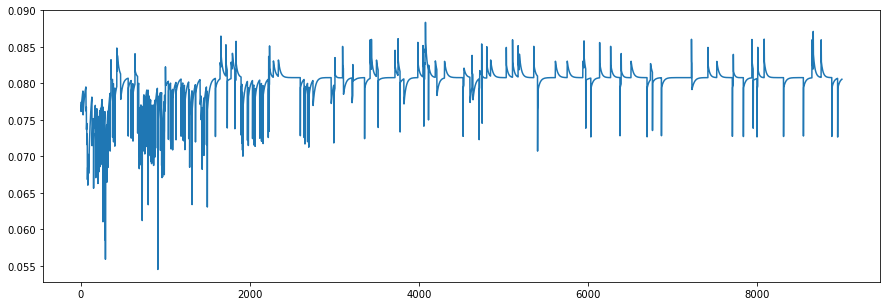

In [10]:
plt.figure(figsize = (15,5))
#plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.flatten().cpu().detach().numpy()[16000:26000])

In [13]:
Z_out = np.zeros((25000,4))

for t in range(25000):
    for n in range(4):
        Z_out[t,n] = torch.argmax(test_Z_out[t,n])

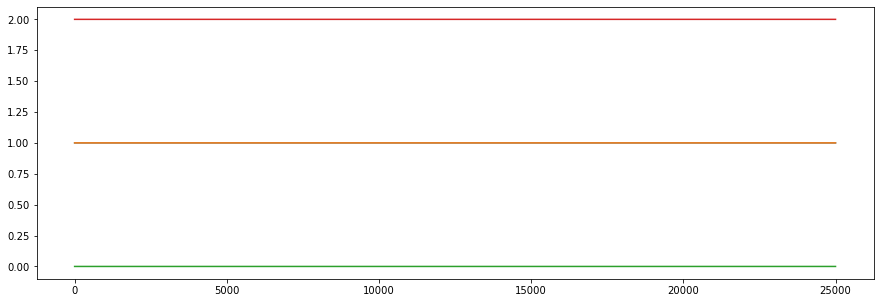

In [14]:
plt.figure(figsize = (15,5))

for n in range(4):
    plt.plot(Z_out[:,n])

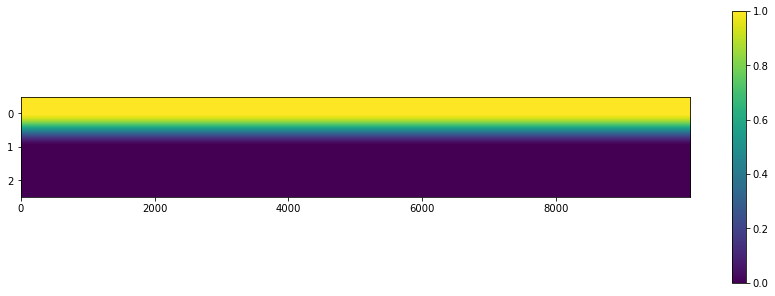

In [25]:
print()